In [1]:
# !pip install torch

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("rocities.txt", "r").read().splitlines()
words[:10]

['1 DECEMBRIE',
 '2 MAI',
 '23 AUGUST',
 'ABRAM',
 'ABRAMUT',
 'ABRUD',
 'ABRUD-SAT',
 'ABUCEA',
 'ABUD',
 'ABUS']

In [4]:
len(words)

10148

In [5]:
# build the vocabulary and mappings to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['*'] = 0
itos = {i: s for s, i in stoi.items()}
print(stoi)
vocab_size = len(itos)
print(itos)
print(vocab_size)

{' ': 1, '-': 2, '.': 3, '1': 4, '2': 5, '3': 6, 'A': 7, 'B': 8, 'C': 9, 'D': 10, 'E': 11, 'F': 12, 'G': 13, 'H': 14, 'I': 15, 'J': 16, 'K': 17, 'L': 18, 'M': 19, 'N': 20, 'O': 21, 'P': 22, 'R': 23, 'S': 24, 'T': 25, 'U': 26, 'V': 27, 'X': 28, 'Y': 29, 'Z': 30, '*': 0}
{1: ' ', 2: '-', 3: '.', 4: '1', 5: '2', 6: '3', 7: 'A', 8: 'B', 9: 'C', 10: 'D', 11: 'E', 12: 'F', 13: 'G', 14: 'H', 15: 'I', 16: 'J', 17: 'K', 18: 'L', 19: 'M', 20: 'N', 21: 'O', 22: 'P', 23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'X', 29: 'Y', 30: 'Z', 0: '*'}
31


In [6]:
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
      context = [0] * block_size
      for ch in w + '*':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([78934, 3]) torch.Size([78934])
torch.Size([9925, 3]) torch.Size([9925])
torch.Size([9837, 3]) torch.Size([9837])


In [7]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(21)  # for reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12741


In [8]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 28.1955
  10000/ 200000: 1.8925
  20000/ 200000: 2.4311
  30000/ 200000: 1.9153
  40000/ 200000: 1.9757
  50000/ 200000: 2.0719
  60000/ 200000: 1.9276
  70000/ 200000: 1.9155
  80000/ 200000: 1.7760
  90000/ 200000: 1.9872
 100000/ 200000: 1.7632
 110000/ 200000: 1.8474
 120000/ 200000: 1.5681
 130000/ 200000: 1.9137
 140000/ 200000: 1.7242
 150000/ 200000: 1.9757
 160000/ 200000: 1.7168
 170000/ 200000: 1.7400
 180000/ 200000: 1.7958
 190000/ 200000: 1.4158


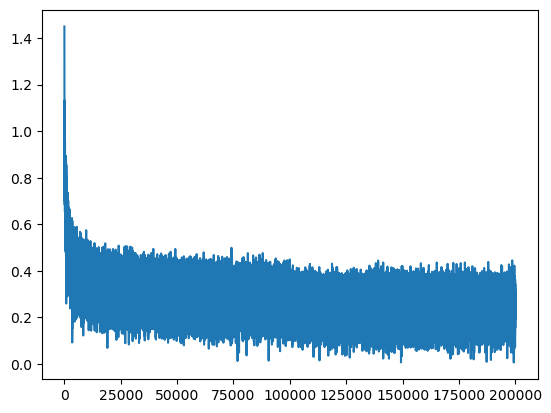

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad()  # disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]  # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1)  # (N, n_hidden)
  logits = h @ W2 + b2  # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7861343622207642
val 1.9248226881027222


In [11]:
# sample from the model
g = torch.Generator().manual_seed(44)

for _ in range(20):
    
    out = []
    context = [0] * block_size  # initialize with all ***
    while True:
      emb = C[torch.tensor([context])]  # (1, block_size, d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

BOIENI-ZARU*
CAMPU DE JOS*
POSTI*
SURN*
LAZOLT*
BUDRU ROAPALINESTI*
LEI*
PLAI*
VALEU*
SALITA*
ION VADULUI*
MURA UILA*
CHESTEI*
GHETI*
SATOINESTI*
FAGURDUNAGUSESTI*
IEZ*
CALNIC*
DILA*
ORZITA LUNGENITA*
